Melbourne Housing Analysis

0) Описание задачи

Датасет о недвижимости Мельбурна, содержащий сведения о продаже домов и квартир.
Каждый объект характеризуется рядом признаков — количеством комнат, площадью участка, годом постройки, количеством ванных,
географическим положением (широта/долгота), расстоянием до центра и т.д. Целевая переменная — **Price**, то есть цена продажи.

Требуется построить предсказательную модель, которая на основе характеристик объекта недвижимости сможет
оценивать его цену. Это задача регрессии, где требуется аппроксимировать зависимость `Price = f(признаки)`.

Признаки:

* Rooms: Number of rooms

- Price: Цена в долларах

- Method: S — имущество продано; SP — имущество продано ранее; PI — имущество передано; PN — продано ранее, цена не разглашается; SN — продано, цена не разглашается; NB — ставка не сделана; VB — ставка продавца; W — отозвано до аукциона; SA — продано после аукциона; SS — продано после аукциона, цена не разглашается. N/A — цена или максимальная ставка недоступны.

- Type: br — спальня(и); h — дом, коттедж, вилла, полудом, терраса; u — квартира, дуплекс; t — таунхаус; dev site — участок под застройку; o res — другое жилое помещение.

- SellerG: агент по недвижимости

- Date: дата продажи

- Distance: расстояние от центрального делового района

- Regionname: общий регион (Запад, Северо-Запад, Север, Северо-Восток и т. д.)

- Propertycount: количество объектов недвижимости в пригороде.

- Bedroom2 : количество спален (из другого источника)

- Bathroom: количество ванных комнат

- Car: количество парковочных мест

- Landsize: площадь участка

- BuildingArea: площадь застройки

- CouncilArea: площадь муниципального образования


In [143]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [144]:
#1. Прочитать данные
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dansbecker/melbourne-housing-snapshot")
path += "/melb_data.csv"
df = pd.read_csv(path)

Using Colab cache for faster access to the 'melbourne-housing-snapshot' dataset.


In [145]:
#2. Разбить данные на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split
X = df.drop(["Price"],axis = 1)
y = df["Price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

N_train, _ = X_train.shape
N_test,  _ = X_test.shape

N_train, N_test

(10185, 3395)

<Axes: xlabel='BuildingArea', ylabel='Price'>

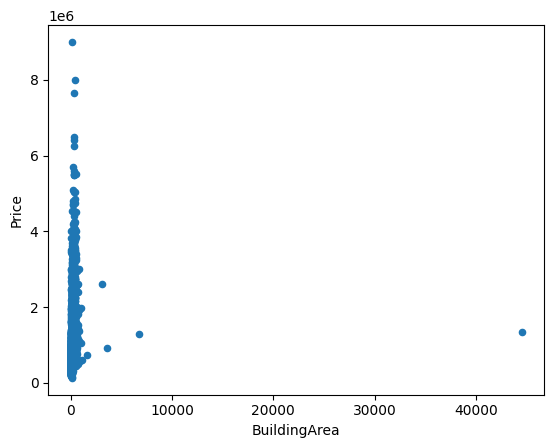

In [146]:
#3. Визуализировать данные и вычислить основные характеристики (среднее, разброс, корреляционную матрицу и т.д.). Интерпретировать.
df.plot(kind='scatter', x='BuildingArea', y='Price')

<Axes: >

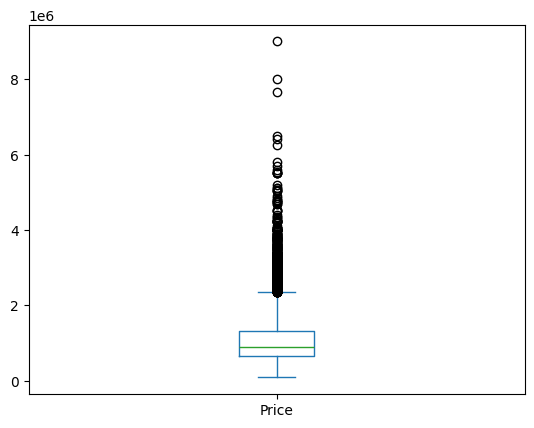

In [147]:
df['Price'].plot(kind='box')

<Axes: >

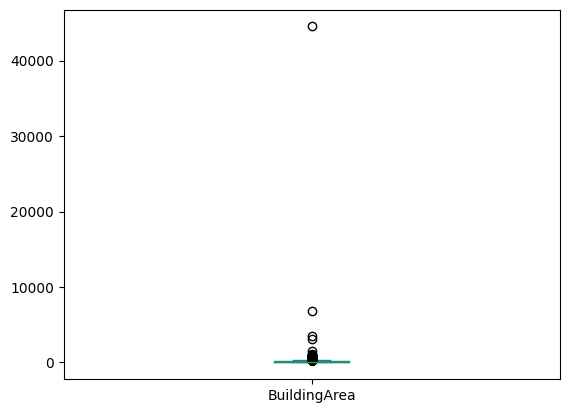

In [148]:
df['BuildingArea'].plot(kind='box')

In [149]:
Q1, Q3 = df['Price'].quantile([.25, .75])
IQR = Q3 - Q1
price_lower = Q1 - 1.5*IQR
price_upper = Q3 + 1.5*IQR

Q1, Q3 = df['BuildingArea'].quantile([.25, .75])
IQR = Q3 - Q1
area_lower = Q1 - 1.5*IQR
area_upper = Q3 + 1.5*IQR

rows_to_drop = df[
    (df['Price'] < price_lower) | (df['Price'] > price_upper) |
    (df['BuildingArea']  < area_lower)  | (df['BuildingArea']  > area_upper)].index
data = df.drop(rows_to_drop)
data.shape

(12753, 21)

<Axes: >

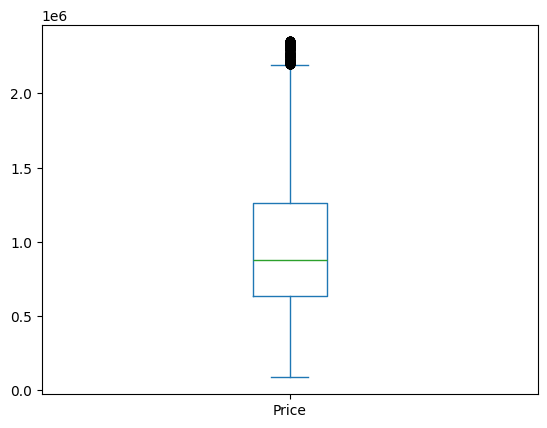

In [150]:
data['Price'].plot(kind='box')

<Axes: >

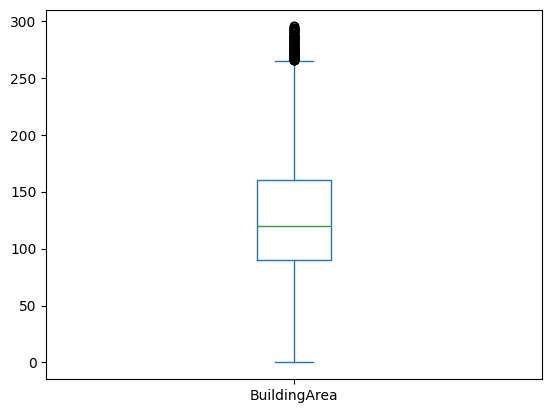

In [151]:
data['BuildingArea'].plot(kind='box')

<Axes: xlabel='BuildingArea', ylabel='Price'>

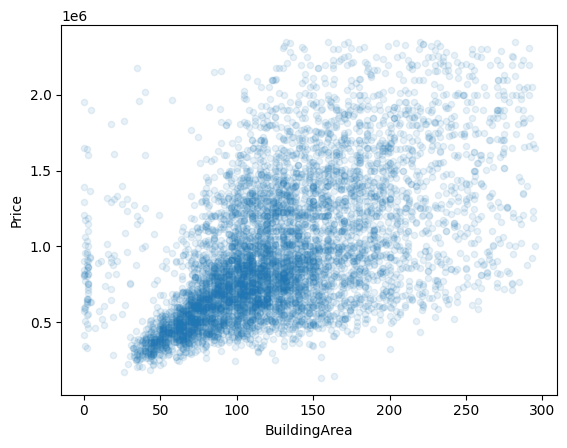

In [152]:
data.plot(kind = 'scatter', x = 'BuildingArea', y = 'Price', alpha=.1)

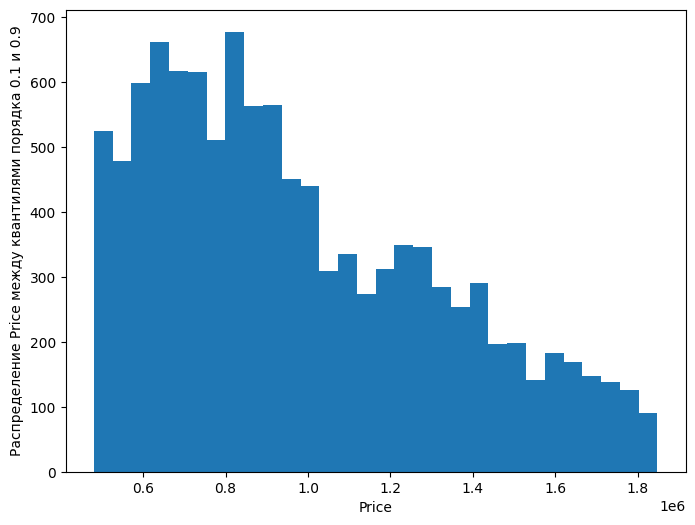

In [153]:
plt.figure(figsize=(8,6))
plt.hist(y[(y<y.quantile(0.9)) & (y > y.quantile(0.1))], bins=30)
plt.xlabel("Price")
plt.ylabel("Распределение Price между квантилями порядка 0.1 и 0.9")
plt.show()

In [154]:
print(y.describe())

count    1.358000e+04
mean     1.075684e+06
std      6.393107e+05
min      8.500000e+04
25%      6.500000e+05
50%      9.030000e+05
75%      1.330000e+06
max      9.000000e+06
Name: Price, dtype: float64


<Axes: >

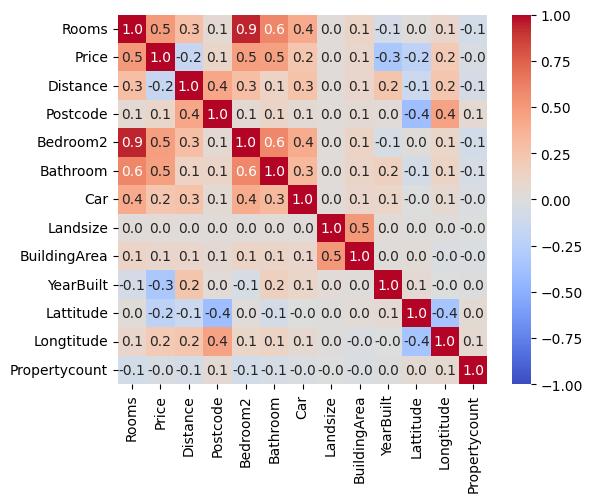

In [155]:
corr_mat = df.corr(numeric_only=1)
sns.heatmap(corr_mat, square=True, vmin=-1, vmax=1, cmap='coolwarm',annot = True, fmt='.1f')

Интерпретация статистик и корреляционной матрицы:

- Среднее и медианное значения цены (Price) показывают общую центральную тенденцию рынка.
Среднее в датасете выше медианы, так как присутствуют экстремально дорогие объекты. Среднее = `1.075684e+06`, медиана = `9.030000e+05`
- Стандартное отклонение отражает разброс цен: большой разброс (`6.393107e+05`) означает сильное разнообразие по типу и классу жилья.
- Корреляционная матрица показывает, насколько сильно связаны между собой признаки.

  * Price положительно коррелирует с количеством комнат (Rooms), количеством ванных (Bathroom) и количеством спален (BEdroom2) — чем больше и комфортнее жильё, тем выше его стоимость.
  Корреляция с площадью здания (BuildingArea) мала, но положительна.
  * Distance (расстояние до центра) имеет отрицательную корреляцию с ценой — чем дальше от центра, тем дешевле жильё.
  * Latitude и Longitude также показывают пространственные зависимости: определённые районы могут быть дороже.
  * Высокие корреляции между признаками (Rooms и Bedroom2, BuildingArea и Landsize) говорят о возможной избыточности информации и мультиколлинеарности.

In [156]:
# 4) Обработка пропущенных значений
missing = X_train.isnull().mean().sort_values(ascending=False)
print('Missing values (fraction):')
print(missing[missing>0])

Missing values (fraction):
BuildingArea    0.473932
YearBuilt       0.396073
CouncilArea     0.101325
Car             0.004516
dtype: float64


(array([ 274., 1495., 2447., 1432.,  699.,  353.,  189.,  103.,   37.,
          29.]),
 array([  0. ,  46.5,  93. , 139.5, 186. , 232.5, 279. , 325.5, 372. ,
        418.5, 465. ]),
 <BarContainer object of 10 artists>)

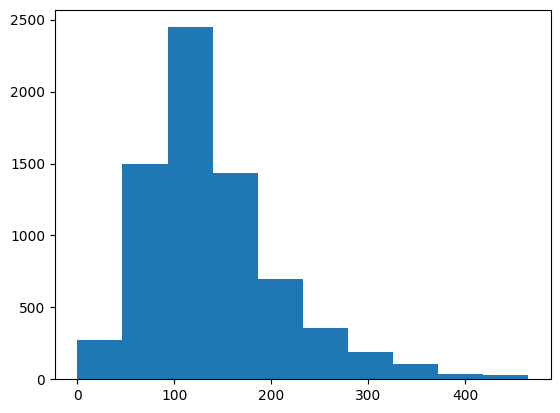

In [157]:
tmp = df[df["BuildingArea"].notnull()]['BuildingArea']
plt.hist(tmp[tmp<tmp.quantile(0.99)])

(array([ 271.,  624.,  370.,  466.,  905.,  902., 1413.,  717.,  989.,
        1452.]),
 array([1884. , 1897.4, 1910.8, 1924.2, 1937.6, 1951. , 1964.4, 1977.8,
        1991.2, 2004.6, 2018. ]),
 <BarContainer object of 10 artists>)

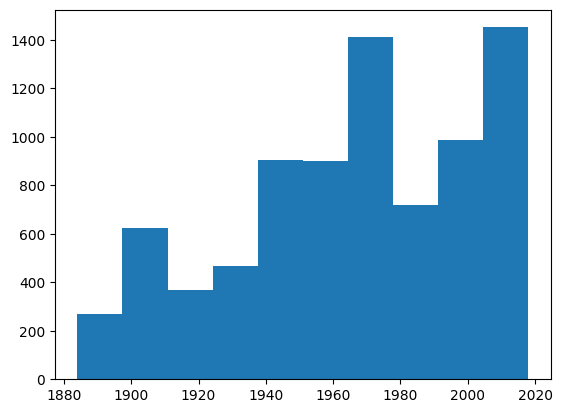

In [158]:
tmp = df[df["YearBuilt"].notnull()]['YearBuilt']
plt.hist(tmp[tmp>tmp.quantile(0.01)])

(array([1026.,    0., 5509.,    0.,    0., 5591.,    0.,  748.,    0.,
         506.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

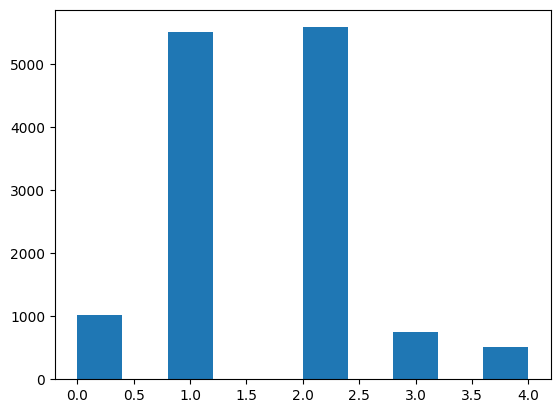

In [159]:
tmp = df[df["Car"].notnull()]['Car']
plt.hist(tmp[tmp<tmp.quantile(0.99)])

In [160]:
#Заменим пропуски медианой, а у строкового признака CouncilArea модой
for col in ['BuildingArea', 'YearBuilt', 'Car']:
  median_val = X_train[col].median()
  X_train[col] = X_train[col].fillna(median_val)
  X_test[col] = X_test[col].fillna(median_val)
mode_val = X_train['CouncilArea'].mode()[0]
X_train['CouncilArea'] = X_train['CouncilArea'].fillna(mode_val)
X_test['CouncilArea'] = X_test['CouncilArea'].fillna(mode_val)

In [161]:
missing = X_train.isnull().mean().sort_values(ascending=False)
print('Missing values (fraction):')
print(missing[missing>0])

Missing values (fraction):
Series([], dtype: float64)


In [162]:
#5. Обработать категориальные признаки
#One hot для признаков с небольшим количеством значений
# Остальные кодируем натуральными числами
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

ohe_cols = [c for c in cat_cols if X_train[c].nunique() <= 10]
label_cols = [c for c in cat_cols if X_train[c].nunique() > 10]

print(f"OHE columns: {ohe_cols}")
print(f"Label-encoded columns: {label_cols}")

if ohe_cols:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    ohe_fit = ohe.fit(X_train[ohe_cols])
    ohe_train = pd.DataFrame(ohe_fit.transform(X_train[ohe_cols]),
                             columns=ohe_fit.get_feature_names_out(ohe_cols),
                             index=X_train.index)
    ohe_test = pd.DataFrame(ohe_fit.transform(X_test[ohe_cols]),
                            columns=ohe_fit.get_feature_names_out(ohe_cols),
                            index=X_test.index)
else:
    ohe_train = pd.DataFrame(index=X_train.index)
    ohe_test = pd.DataFrame(index=X_test.index)

X_train_le = X_train.copy()
X_test_le = X_test.copy()

for col in label_cols:
    le = LabelEncoder()
    le.fit(X_train[col].astype(str))
    X_train_le[col] = le.transform(X_train[col].astype(str))

    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    X_test_le[col] = X_test[col].astype(str)
    X_test_le[col] = X_test_le[col].replace(mapping)
    X_test_le[col] = X_test_le[col].apply(lambda x: -1 if x not in mapping else x)


X_train_final = pd.concat([X_train_le.drop(columns=ohe_cols, errors='ignore'), ohe_train], axis=1)
X_test_final = pd.concat([X_test_le.drop(columns=ohe_cols, errors='ignore'), ohe_test], axis=1)

print(f"Итоговые размеры: {X_train_final.shape}, {X_test_final.shape}")


OHE columns: ['Type', 'Method', 'Regionname']
Label-encoded columns: ['Suburb', 'Address', 'SellerG', 'Date', 'CouncilArea']
Итоговые размеры: (10185, 33), (3395, 33)


/tmp/ipython-input-2391663738.py:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test_le[col] = X_test_le[col].replace(mapping)
/tmp/ipython-input-2391663738.py:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test_le[col] = X_test_le[col].replace(mapping)


In [163]:
#6. Провести нормализацию
num_cols = X_train_final.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()

X_train_scaled = X_train_final.copy()
X_test_scaled = X_test_final.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train_final[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test_final[num_cols])



Аргументация выбора модели

В качестве основной модели была выбрана модель K-ближайших соседей (KNN).
Основная идея метода — предсказать значение целевой переменной для нового объекта, основываясь на значениях целевой переменной у ближайших по признаковому пространству объектов обучающей выборки.

Преимущества:

Малая настройка модели — основной гиперпараметр k (число соседей) легко подбирается с помощью кросс-валидации;

Хорошая база для сравнения — KNN часто используется как базовая модель, с которой сравнивают более сложные алгоритмы.

В данной задаче KNN был выбран именно как первый базовый регрессор, позволяющий понять общую структуру данных и зависимость между признаками и ценой.

In [164]:
knn = KNeighborsRegressor(weights='distance')
param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,

)

grid_search.fit(X_train_scaled, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший RMSE (CV):", -grid_search.best_score_)


best_knn = grid_search.best_estimator_
y_pred_train = best_knn.predict(X_train_scaled)

train_rmse = root_mean_squared_error(y_train, y_pred_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

print(f"Train RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}, R2: {train_r2:.3f}")

y_pred_test = best_knn.predict(X_test_scaled)
test_rmse = root_mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Test RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}, R2: {test_r2:.3f}")

Лучшие параметры: {'n_neighbors': 12, 'weights': 'distance'}
Лучший RMSE (CV): 383916.9252335274
Train RMSE: 0.11, MAE: 0.04, R2: 1.000
Test RMSE: 392352.84, MAE: 257823.80, R2: 0.618


`Train RMSE: 0.11, MAE: 0.04, R2: 1.000`

`Test RMSE: 392352.84, MAE: 257823.80, R2: 0.618`

Идеальные показатели метрик на обучающей выборке говорят о том, что модель переобучилась и практически запомнила обучающую выборку.

На тесте модель объясняет лишь 61.8% дисперсии цен, то есть имеет низкую обобщающую способность

In [165]:
rf = RandomForestRegressor(random_state=42)

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20]
}

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_rf.fit(X_train_scaled, y_train)

print("Лучшие параметры Random Forest:")
print(grid_rf.best_params_)
print("Лучший RMSE (CV):", -grid_rf.best_score_)

best_rf = grid_rf.best_estimator_

y_pred_train = best_rf.predict(X_train_scaled)

train_rmse = root_mean_squared_error(y_train, y_pred_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

print(f"Train RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}, R2: {train_r2:.3f}")

y_pred_test = best_rf.predict(X_test_scaled)
test_rmse = root_mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Test RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}, R2: {test_r2:.3f}")


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Лучшие параметры Random Forest:
{'max_depth': 20, 'n_estimators': 200}
Лучший RMSE (CV): 298292.0349840005
Train RMSE: 111815.15, MAE: 64769.21, R2: 0.970
Test RMSE: 330010.46, MAE: 217859.48, R2: 0.730


Random Forest показал более сбалансированные результаты между обучающей и тестовой выборкой.
Он не переобучается так сильно, как KNN, и лучше улавливает закономерности, не теряя при этом способность к обобщению.
Таким образом, для предсказания цены недвижимости Random Forest оказался чуть более подходящим

Общие выводы по заданию

- Данные успешно загружены, очищены и подготовлены: пропуски были корректно обработаны, категориальные признаки закодированы, числовые — нормализованы.

- Проведён разведочный анализ данных, показавший значительные различия в масштабе признаков и умеренные корреляции между ключевыми переменными.

- KNN показал идеальное качество на обучающей выборке, но высокую ошибку на тесте, что говорит о переобучении.

- Random Forest дал более стабильные результаты, сохранив высокое качество при лучшей способности к обобщению.

- Оптимизация гиперпараметров через GridSearchCV позволила подобрать лучшие настройки для обеих моделей.